Recurrent Autoencoder with Fashion MNIST
===

- GRU-based Autoencoder.
- Speed up by binary_crossentropy in calculating reconstruction loss.

# Setup

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# @title utility function to render image
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Load training data


In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_train.shape

4422102/4422102 [==============================] - 1s 0us/step


(55000, 28, 28)

# Recurrent Autoencoder

- To make the learning speed faster, binary crossentropy can be used to calculate the loss by rounding the pixcel values to 0 or 1.
- This is possible because the trainign data is gray scaled.

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(
        tf.round(y_true), # round to 0 or 1 to use binary_crossentropy
        tf.round(y_pred))

In [5]:
LATENT_DIM = 30
IMAGE_SIZE = 28
HIDDEN_DIM = 100
LEARNING_RATE = 0.1

encoder = keras.models.Sequential([
    keras.layers.LSTM(HIDDEN_DIM, input_shape=(IMAGE_SIZE, IMAGE_SIZE), return_sequences=True),
    keras.layers.LSTM(LATENT_DIM), # caution: not Dense
])
decoder = keras.models.Sequential([
    keras.layers.RepeatVector(IMAGE_SIZE, input_shape=[LATENT_DIM]),
    keras.layers.LSTM(HIDDEN_DIM, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(IMAGE_SIZE, activation='sigmoid')),
])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(
    # 多ラベル２項分類問題として扱い、個々のピクセルの明度はピクセルを黒にすべき確率を表す
    # 回帰問題とするよりも収束が早くなる
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),

    # 正解率は個々のピクセルのラベルが0か1であることを前提としているのでカスタム指標が必要
    # 正解と予測を0か1に丸めてから正解率を計算する必要がある
    metrics=[rounded_accuracy]
)
print(autoencoder.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                67320     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            55228     
                                                                 
Total params: 122548 (478.70 KB)
Trainable params: 122548 (478.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [6]:
LATENT_DIM = 30
IMAGE_SIZE = 28
HIDDEN_DIM = 100
LEARNING_RATE = 0.1

encoder = keras.models.Sequential([
    keras.layers.GRU(HIDDEN_DIM, input_shape=(IMAGE_SIZE, IMAGE_SIZE), return_sequences=True),
    keras.layers.GRU(LATENT_DIM), # caution: not Dense
])
decoder = keras.models.Sequential([
    keras.layers.RepeatVector(IMAGE_SIZE, input_shape=[LATENT_DIM]),
    keras.layers.GRU(HIDDEN_DIM, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(IMAGE_SIZE, activation='sigmoid')),
])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(
    # 多ラベル２項分類問題として扱い、個々のピクセルの明度はピクセルを黒にすべき確率を表す
    # 回帰問題とするよりも収束が早くなる
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),

    # 正解率は個々のピクセルのラベルが0か1であることを前提としているのでカスタム指標が必要
    # 正解と予測を0か1に丸めてから正解率を計算する必要がある
    metrics=[rounded_accuracy]
)
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 30)                50880     
                                                                 
 sequential_4 (Sequential)   (None, 28, 28)            42428     
                                                                 
Total params: 93308 (364.48 KB)
Trainable params: 93308 (364.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=20,
                          validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 25s 10ms/step - loss: 0.4825 - rounded_accuracy: 0.7815 - val_loss: 0.4338 - val_rounded_accuracy: 0.8216
Epoch 2/20
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4186 - rounded_accuracy: 0.8284 - val_loss: 0.4095 - val_rounded_accuracy: 0.8328
Epoch 3/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3974 - rounded_accuracy: 0.8402 - val_loss: 0.3833 - val_rounded_accuracy: 0.8532
Epoch 4/20
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3702 - rounded_accuracy: 0.8624 - val_loss: 0.3629 - val_rounded_accuracy: 0.8686
Epoch 5/20
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3569 - rounded_accuracy: 0.8734 - val_loss: 0.3556 - val_rounded_accuracy: 0.8768
Epoch 6/20
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3503 - rounded_accuracy: 0.8795 - val_loss: 0.3486 - val_rounded_accuracy: 0.8812
Epoch 7/20
1719/1719 [===========

Retrieve some image samples and pass through autoencoder
and compare the inputs with the reconstructed ones.

In [8]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 1s 804ms/step


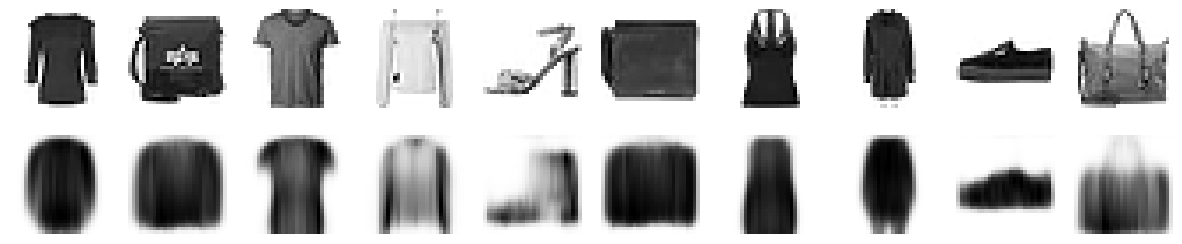

In [9]:
show_reconstructions(autoencoder)